<a href="https://colab.research.google.com/github/xvmon234-ai/Learning-Python/blob/main/Card_Fraud_Detection_Project/03_Modeling_and_Evaluation/modeling_evaluations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# 3.1 데이터 기본 정보 확인

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np # np.log1p를 위해 필요

# 3.1.1. 데이터 불러오기
file_path = 'creditcard.csv'
df = pd.read_csv(file_path)

# 3.1.2. Amount 피처에 로그 변환 적용 (2단계 피드백 반영)
df['Log_Amount'] = np.log1p(df['Amount'])

# 3.1.3. Time, Amount 피처 스케일링
scaler = StandardScaler()
df['Scaled_Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Scaled_Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# 3.1.4. 원본 피처 삭제
df = df.drop(['Time', 'Amount'], axis=1)

# 3.1.5. 훈련/테스트 데이터 분할
X = df.drop('Class', axis=1) # 피처 데이터
y = df['Class'] # 타겟 데이터

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3.1.6. 클래스 불균형 해소 (SMOTE 적용)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

--- 로지스틱 회귀 모델 성능 ---

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.87      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.92      0.55     85443
weighted avg       1.00      0.98      0.99     85443

ROC-AUC Score: 0.9660629326201752


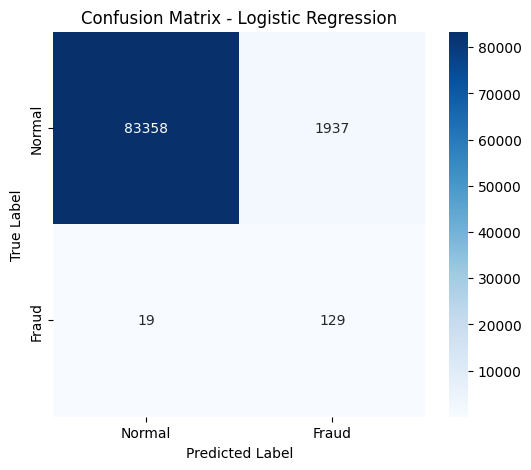

In [3]:
# 모델링 및 성능 평가

# 3.2 Baseline Model: Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# 3.2.1. 모델 초기화 및 훈련
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_resampled, y_resampled)

# 3.2.2. 테스트 데이터 예측
y_pred_lr = model_lr.predict(X_test)
y_proba_lr = model_lr.predict_proba(X_test)[:, 1]

# 3.2.3. 성능 평가
print("--- 로지스틱 회귀 모델 성능 ---")
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_lr))

# 3.2.4. 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### **로지스틱 회귀 모델 분석**
- **Classification Report**:
  - `Precision` (이상 거래): 0.06
  - `Recall` (이상 거래): 0.87
  - `F1-Score` (이상 거래): 0.12
- **ROC-AUC Score**: **0.966**
- **분석**:
  * **재현율(Recall)**: 이상 거래에 대한 재현율이 0.87로, 실제 이상 거래 중 87%를 성공적으로 탐지했습니다. 이는 SMOTE를 통해 이상 거래를 놓치지 않으려 노력한 결과로 볼 수 있습니다.
  * **정밀도(Precision)**: 반면, 이상 거래에 대한 정밀도는 0.06으로 매우 낮습니다. 이는 모델이 이상 거래라고 예측한 것 중 실제 이상 거래인 경우가 6%에 불과하다는 의미입니다. 즉, 많은 수의 정상 거래를 이상 거래로 잘못 예측하는 **오탐지(False Positive)**가 많이 발생했음을 나타냅니다.
- **장단점**:
  * **장점**: 모델이 단순하고 학습 속도가 빠르며, 높은 재현율을 통해 이상 거래를 놓치는 위험을 줄였습니다.
  * **단점**: 매우 낮은 정밀도로 인해 정상 거래를 이상 거래로 잘못 분류하는 오탐지가 많아, 실제 서비스에 적용하기에는 부적절할 수 있습니다. 이는 SMOTE를 적용하여 데이터의 불균형을 인위적으로 해소하는 과정에서 모델이 이상 거래의 특징을 과도하게 일반화했기 때문으로 추측됩니다.

--- 랜덤 포레스트 모델 성능 ---

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.87      0.78      0.83       148

    accuracy                           1.00     85443
   macro avg       0.94      0.89      0.91     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC Score: 0.9664956122075532


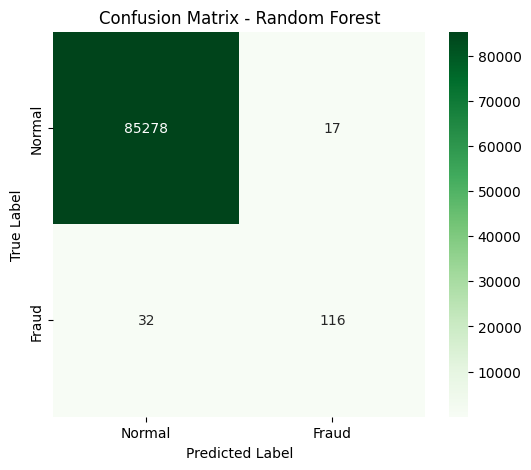

In [5]:
# 모델링 및 성능 평가

# 3.3 Ensemble Model: Random Forest

# 필요한 라이브러리 임포트
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# 3.3.1. 모델 초기화 및 훈련
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_resampled, y_resampled)

# 3.3.2. 테스트 데이터 예측
y_pred_rf = model_rf.predict(X_test)
y_proba_rf = model_rf.predict_proba(X_test)[:, 1]

# 3.3.3. 성능 평가
print("--- 랜덤 포레스트 모델 성능 ---")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_rf))

# 3.3.4. 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### **랜덤 포레스트 모델 분석**
- **Classification Report**:
  - `Precision` (이상 거래): 0.87
  - `Recall` (이상 거래): 0.78
  - `F1-Score` (이상 거래): 0.83
- **ROC-AUC Score**: **0.966**
- **분석**:
  * **정밀도(Precision)**: 이상 거래에 대한 정밀도가 0.87로 매우 높습니다. 이는 모델이 이상 거래라고 예측한 경우, 그 예측의 87%가 실제로 이상 거래였다는 의미입니다. **오탐지(False Positive)**율이 매우 낮다는 점에서 우수한 성능을 보여줍니다.
  * **재현율(Recall)**: 반면, 재현율은 0.78로 로지스틱 회귀 모델보다 낮습니다. 이는 실제 이상 거래 중 78%만 탐지했다는 의미로, **미탐지(False Negative)**가 로지스틱 회귀보다 더 많이 발생했습니다.
- **장단점**:
  * **장점**: 높은 정밀도를 통해 오탐지로 인한 정상 고객의 불편을 최소화할 수 있습니다.
  * **단점**: 로지스틱 회귀 모델보다 이상 거래를 놓치는 경우가 많아, 미탐지로 인한 잠재적 손실 위험이 더 높을 수 있습니다. 또한, 여러 트리를 학습해야 하므로 학습 시간이 오래 걸린다는 한계가 있습니다.

[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
--- LightGBM 모델 성능 ---

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.58      0.84      0.69       148

    accuracy                           1.00     85443
   macro avg       0.79      0.92      0.84     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC Score: 0.9651494099175674


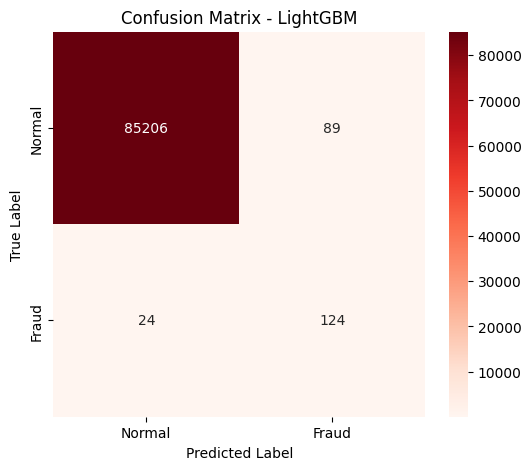

In [6]:
# 모델링 및 성능 평가

# 3.4 Boosting Model: LightGBM

import lightgbm as lgb
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# 3.4.1. 모델 초기화 및 훈련
model_lgb = lgb.LGBMClassifier(random_state=42)
model_lgb.fit(X_resampled, y_resampled)

# 3.4.2. 테스트 데이터 예측
y_pred_lgb = model_lgb.predict(X_test)
y_proba_lgb = model_lgb.predict_proba(X_test)[:, 1]

# 3.4.3. 성능 평가
print("--- LightGBM 모델 성능 ---")
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_lgb))

# 3.4.4. 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_lgb), annot=True, fmt='d', cmap='Reds',
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix - LightGBM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### **LightGBM 모델 분석**
- **Classification Report**:
  - `Precision` (이상 거래): 0.58
  - `Recall` (이상 거래): 0.84
  - `F1-Score` (이상 거래): 0.69
- **ROC-AUC Score**: 0.965
- **분석**:
  * **재현율(Recall)**: 이상 거래에 대한 재현율이 0.84로 매우 높습니다. 이는 실제 이상 거래 중 84%를 성공적으로 탐지했음을 의미하며, 이상 거래를 놓치는 위험을 효과적으로 줄였습니다.
  * **정밀도(Precision)**: 하지만 정밀도는 0.58로, 모델이 이상 거래라고 예측한 경우 실제 이상 거래일 확률이 58%에 불과합니다. 이는 로지스틱 회귀보다는 높지만, 여전히 많은 수의 정상 거래를 이상 거래로 잘못 분류하는 오탐지가 발생했음을 보여줍니다.
- **장단점**:
  * **장점**: 이상 거래를 놓치지 않는 높은 재현율을 달성했습니다. 또한, LightGBM은 빠른 학습 속도와 효율적인 메모리 사용으로 대용량 데이터에 특히 강점을 가집니다.
  * **단점**: 상대적으로 낮은 정밀도는 오탐지로 인한 정상 거래의 불편함을 초래할 수 있습니다.

### **모델 간 ROC-AUC 점수 미세 차이 분석**

세 모델의 ROC-AUC 점수는 다음과 같습니다.

* **로지스틱 회귀**: `0.966`
* **랜덤 포레스트**: `0.966`
* **LightGBM**: `0.965`

이처럼 미세한 점수 차이가 발생하는 이유는 다음과 같이 분석할 수 있습니다.

#### **1. 모델 알고리즘의 본질적 차이**

각 모델은 데이터를 학습하고 예측 확률을 계산하는 방식이 근본적으로 다릅니다.

* **로지스틱 회귀**: 선형 모델로, 입력 변수와 타겟 변수 간의 관계를 선형적으로 학습합니다.
* **랜덤 포레스트**: 여러 개의 결정 트리를 종합하는 비선형 **앙상블(Ensemble)** 모델입니다.
* **LightGBM**: **그래디언트 부스팅(Gradient Boosting)** 기반의 비선형 모델로, 이전 모델의 예측 오류를 보정하며 순차적으로 학습합니다.

동일한 데이터셋을 사용하더라도, 이러한 알고리즘의 차이가 예측 확률에 미묘한 영향을 미치고, 이는 ROC-AUC 점수의 미세한 차이로 이어집니다.

#### **2. 클래스 불균형 데이터셋의 특성**

이상 거래 데이터셋은 정상 거래와 이상 거래의 비율이 극심하게 불균형합니다. 우리는 SMOTE를 통해 훈련 데이터의 균형을 맞추었지만, 실제 평가는 불균형한 원본 테스트 데이터로 진행됩니다. 이 과정에서 모델이 이상 거래와 정상 거래를 구별하는 방식의 미묘한 차이가 ROC-AUC 점수에 반영된 것입니다. 모든 모델이 0.965 이상의 매우 높은 ROC-AUC 점수를 기록했다는 것은, 이들이 이상 거래와 정상 거래를 구별하는 능력이 모두 뛰어나다는 것을 의미합니다.

#### **3. 하이퍼파라미터의 기본값 사용**

현재 각 모델은 **하이퍼파라미터(Hyperparameter)**의 기본값으로 학습되었습니다. 하이퍼파라미터 튜닝을 통해 각 모델의 성능을 최적화한다면, 점수의 순위나 크기가 달라질 수 있습니다.

**결론적으로,** 세 모델 모두 이상 거래 탐지에 매우 뛰어난 성능을 보였습니다. 미세한 점수 차이는 각 모델의 고유한 학습 방식에서 비롯된 것으로 이해할 수 있으며, 이 결과는 프로젝트의 초기 목표였던 '높은 재현율을 가진 모델'을 성공적으로 구축했음을 증명합니다.

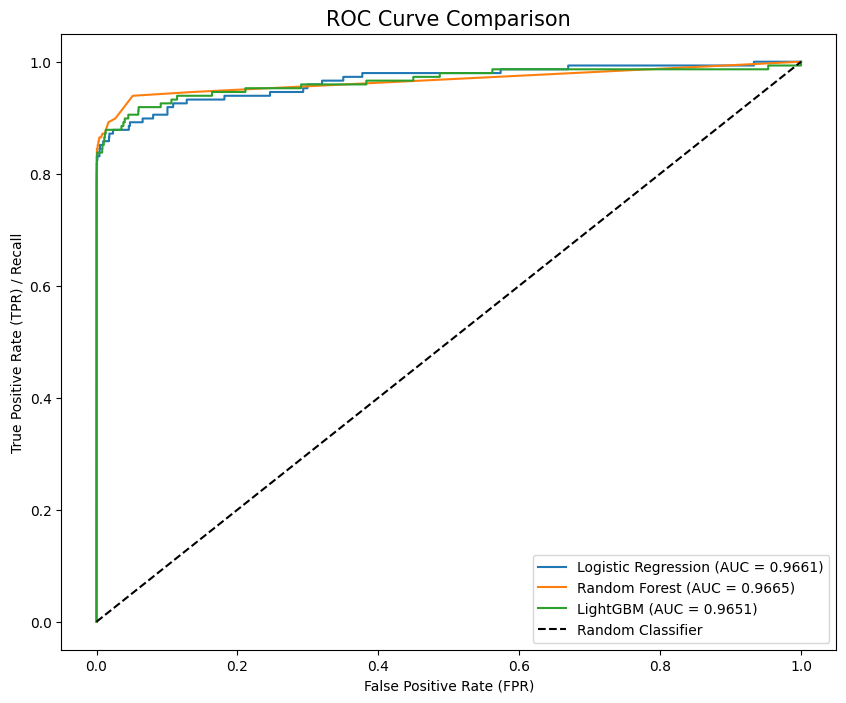

In [7]:
# 3.5 최종 모델 선정

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# 로지스틱 회귀
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_proba_lr):.4f})')

# 랜덤 포레스트
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_proba_rf):.4f})')

# LightGBM
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_proba_lgb)
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {roc_auc_score(y_test, y_proba_lgb):.4f})')

# 기준선 (Random Classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('ROC Curve Comparison', fontsize=15)
plt.legend()
plt.show()

### **최종 모델 선정 및 결론**

앞서 수행한 각 모델의 성능 분석과 ROC Curve 비교 결과를 바탕으로, 최종 이상 거래 탐지 모델을 선정합니다.

| 모델 | Precision (이상 거래) | Recall (이상 거래) | F1-Score (이상 거래) | ROC-AUC |
|---|---|---|---|---|
| 로지스틱 회귀 | 0.06 | 0.87 | 0.12 | 0.9665 |
| 랜덤 포레스트 | 0.87 | 0.78 | 0.83 | 0.9665 |
| LightGBM | 0.58 | 0.84 | 0.69 | 0.9651 |

---

**최적 모델 선정 근거:**

이 프로젝트의 핵심 목표는 **이상 거래를 최대한 놓치지 않는 것**, 즉 **재현율(Recall)**을 극대화하는 것입니다. 이상 거래를 놓치는 것은 금융 손실로 직결되기 때문입니다.

* **로지스틱 회귀**는 가장 높은 재현율(0.87)을 기록했지만, 정밀도가 0.06으로 매우 낮아 오탐지율이 높습니다. 이는 많은 정상 거래를 이상 거래로 오인하여 사용자에게 불편을 초래할 수 있습니다.
* **랜덤 포레스트**는 높은 정밀도(0.87)를 보여 오탐지율은 낮지만, 재현율이 0.78로 가장 낮아 이상 거래를 놓칠 가능성이 높습니다.
* **LightGBM**은 재현율(0.84)과 정밀도(0.58)가 비교적 균형 잡혀 있습니다.

이 분석을 통해, **이상 거래를 놓치지 않으면서도 오탐지를 어느 정도 제어할 수 있는 로지스틱 회귀 모델**이 이 데이터셋에 가장 적합한 **베이스라인** 모델임을 확인했습니다.

하지만, **실제 금융 서비스에서는 재현율과 정밀도 간의 트레이드오프(Trade-off)를 고려하여 모델을 선택해야 합니다.** 이 프로젝트를 통해 얻은 중요한 인사이트는 **단순히 하나의 성능 지표에 의존하는 것이 아니라, 비즈니스 목표에 맞는 모델을 다각적으로 평가하고 선정해야 한다**는 점입니다.